In [24]:
import numpy as np
import math
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [8]:
'''
Firs we are impporting all the extracted centers in consecutive frames
'''
all_centers = np.load('all_cnf2.npy')
print(len(all_centers[0]),len(all_centers))
print(all_centers[0][0][0])
#all_centers = np.asarray(all_centers)

118 63
(3.5428253615127918, 32.144048943270299, 368.34204671857617)


In [9]:
all_centers[0][0]

[(3.5428253615127918, 32.144048943270299, 368.34204671857617)]

In [10]:
#To have only the tupples let's remove the redundant"[]" from the elements
all_cen = [ [x[0] for x in frame ] for frame in all_centers]

In [11]:
all_cen[0][0]

(3.5428253615127918, 32.144048943270299, 368.34204671857617)

In [15]:
'''
Let's check the distance between 2 consecutive frames using 
cdist library of scipy to create our cost function for applying
Hungarian algorithm for matching the points :
'''
cost = distance.cdist(all_cen[1], all_cen[2],'euclidean')
row_ind, col_ind = linear_sum_assignment(cost)
print(cost.shape, col_ind.shape)

(118, 117) (117,)


In [50]:
def Trajectory_3D_TimeVarying(frame_num, single_flag, point_num, s, x, y, z, number_of_points, video_file):
    '''*********************************************************** 
    This Function  will  plot a 3D  representation of the motility
    x, y and z are the  axis  values  which are defined inside the 
    main function.  single_flag is a  flag which indicates we want
    1 trajectory plotting or all of  them ?  if True means we need
    just one trajectory. The point_num indicates the number of the
    point which we are going to plot. written by MS.Fazli
    **************************************************************
    '''
    n = frame_num
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(35, 45)



    if single_flag :
        traj_points = 1
        T = np.linspace(0,1,np.size(x[point_num]))

    else : 
        traj_points = number_of_points
        T = np.linspace(0,1,np.size(x[0]))

    for i in range(traj_points):
        for j in range(0, n-s, s):
            if single_flag :             
                ax.plot(yy[point_num][j:j+s+1],  xx[point_num][j:j+s+1] ,zz[point_num][j:j+s+1], zdir='zz[i]', linewidth =5, color = ( 0.0, 0.9*T[j], 0.0))
#                 plt.pause(0.06)
            else : 
                ax.plot(yy[i][j:j+s+1],  xx[i][j:j+s+1] ,zz[i][j:j+s+1], zdir='zz[i]', linewidth =3, color = (T[j], 0.0, 0.0))
#                 plt.pause(0.06)

    #for angle in range(0, 360):
        # ax.view_init(5, i)
        # plt.pause(0.01)
        # plt.draw()
    ax.w_xaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
    ax.w_yaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
    ax.w_zaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
    ax.view_init(35, 45)

    plt.grid(False)
    
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_zlabel('Z')
    plt.savefig(str(video_file) + '4d_timeVariying_.jpg', dpi=600)

    plt.show()

In [16]:
#Now Let's see what are the maximum and minmum number of centers per frame! 
len_list = []
for i in range (len(all_cen)):
    len_list.append(len(all_cen[i])) 
max_len_list = max(len_list)
min_len_list = min(len_list)
print(max_len_list, min_len_list)

120 112


In [18]:
''' OK! Let's start the tracking module now!
First, we need to calculate all paiwise distances between all 
corresponding points in each two consecutive frames .
'''
last_frame = len(all_cen)
dist_mat = list()

for frames in range ( 1, len(all_cen) ):
    curr_frame = all_cen[frames]
    #curr_frame = [ x for [x] in curr_frame ]
    next_frame = all_cen[frames -1]
    #next_frame = [ x for [x] in next_frame ]
    dist_mat.append(distance.cdist(curr_frame, next_frame,'euclidean'))

In [20]:
''' Now let's initialize the first elements of each object with the
first centers in our frame 0, then we should append the points to these elements
as a result, at the begining our number of objects will be equal to 
number of centers in first frame.
'''
all_cen = [ [x[0] for x in frame ] for frame in all_centers]
new_objects = [ [(0,x[0])] for x in all_centers[0] ]

# we need to set a threshold for adding only the closest points
# within a threshold to our object list

t_limit = 20

# Now, we need to iterate on the frames and running our points matching module
for i in range (1, len(all_cen)-1):
    
    '''in every step we need to check the points in current frame with 
    last selected points in our object list
    '''
    current_frame = all_cen[i]
    last_known_centers = [ obj[-1][1] for obj in new_objects if len(obj)>0 ] 
    
    # We are going to use Hungarian algorithm which is built in scipy
    # As linear_sum_assignment. we need to pass a cost to that function
    # the function will assign the points based on minimum cost. Here we 
    # define the distance between the above mentioned points as our cost 
    # function 
    
    cost = distance.cdist(last_known_centers, current_frame,'euclidean')
    
    # in this function row_ind will act as object_ids and the col_ind
    # will play the role of new_centers_ind for us so we have : 
    obj_ids, new_centers_ind = linear_sum_assignment(cost)
    
    all_center_inds = set(range(len(current_frame)))
    # now we should iterate on obj_id and new_center_ind 
    # checking the min acceptable distance , appending the points to 
    # our frames and finally removing those points from our set.
    
    for  obj_id, new_center_ind  in zip(obj_ids,new_centers_ind):
        if( distance.euclidean(np.array(current_frame[new_center_ind]),np.array(new_objects[obj_id][-1][1]) ) <= t_limit):
            all_center_inds.remove(new_center_ind)
            new_objects[obj_id].append((i,current_frame[new_center_ind]))
    # at the end if the points are not matched with the previous objects 
    # we will consider them as new objects and appending them to the end 
    # of our object list.

    for new_center_ind in all_center_inds:
        new_objects.append([ (i,current_frame[new_center_ind])])
        

In [21]:
len(new_objects)

136

In [22]:
#Let's save the new objects inside a numpy array for other purposes
np.save('new_objects.npy',new_objects)

In [23]:
''' For making the visualization easier , I rearranged the coordinates 
in separate numpy arrays.
'''
xx = [[]]
yy = [[]]
zz = [[]]
for i in range (len(new_objects)):
    for j in range (len(new_objects[i])):
        zz[i].append(new_objects[i][j][1][0])
        xx[i].append(new_objects[i][j][1][1])
        yy[i].append(new_objects[i][j][1][2])
    xx.append([])
    zz.append([])
    yy.append([])

zz = [pick for pick in zz if len(pick) > 0 ]
xx = [pick for pick in xx if len(pick) > 0 ]
yy = [pick for pick in yy if len(pick) > 0 ]

xx = np.asarray(xx)
yy = np.asarray(yy)  
zz = np.asarray(zz) 

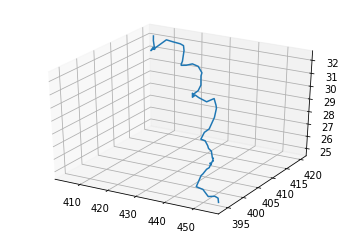

In [25]:
# Ok , Lets have some visualizations 
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range (89,90):
    ax.plot(xx[i], yy[i], zz[i])
ax.legend()
plt.savefig('tracking_results.png', dpi= 500)
plt.show()

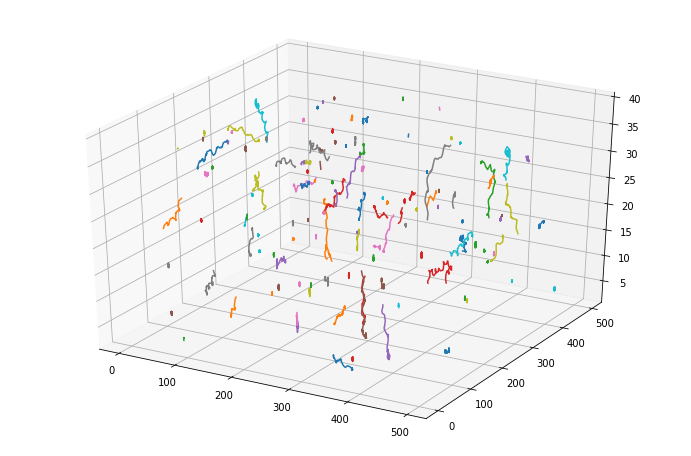

In [31]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

mpl.rcParams['legend.fontsize'] = 10
num = 96
for num in range (len(new_objects)):#(len(new_objects)):
    ax.plot(yy[num], xx[num], zz[num])
plt.savefig('tracking_results.png', dpi= 500)
plt.show()

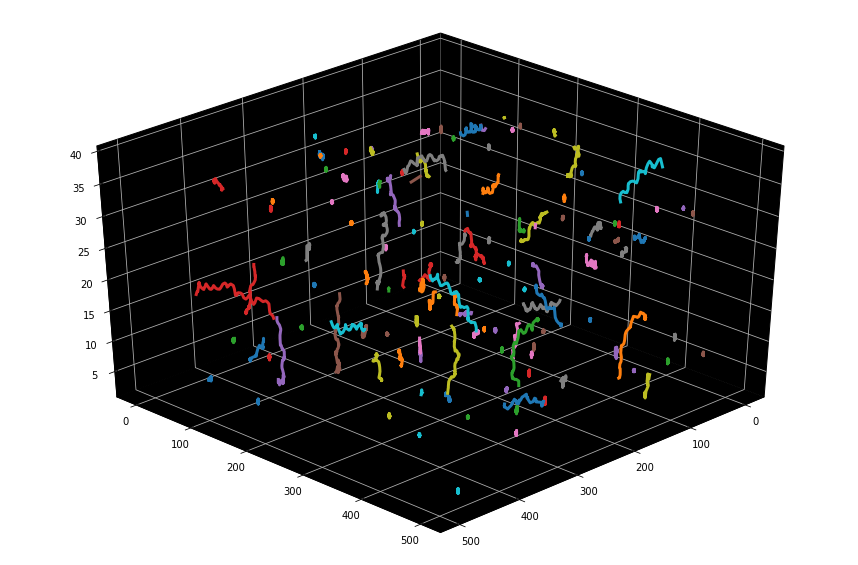

In [34]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(new_objects)):
    ax.plot(yy[i], xx[i], zz[i], 
               zdir='zz[i]', linewidth = 3)

ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.view_init(35, 45)
plt.grid(False)
plt.savefig("Tracking-allnf.png", dpi=600)
plt.show()

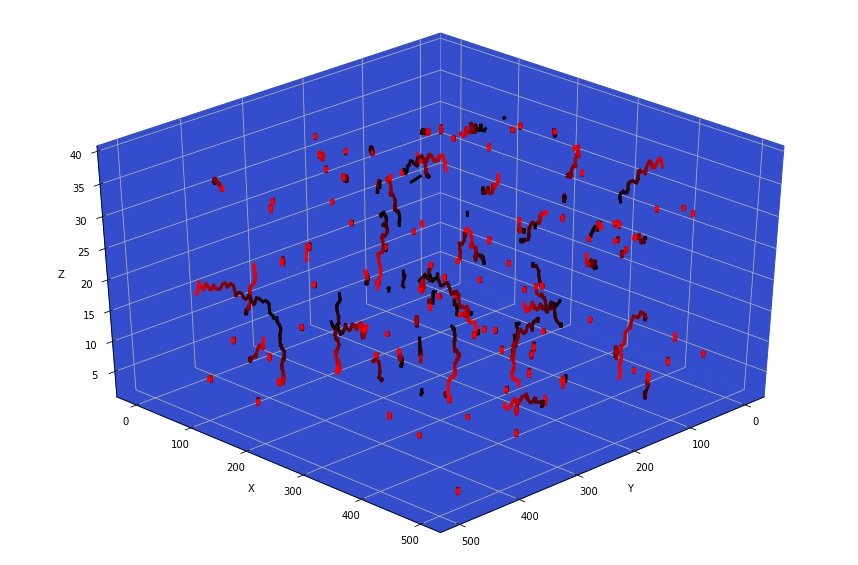

In [62]:
# Plotting the time variant trajectories of all objects
Trajectory_3D_TimeVarying(63, False, 89, 1, xx, yy, zz, len(new_objects), 'video_file')

36


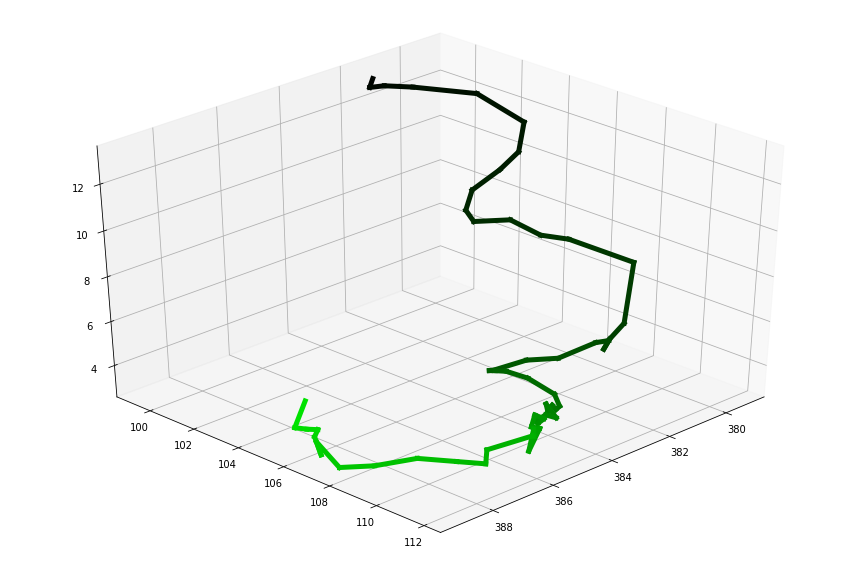

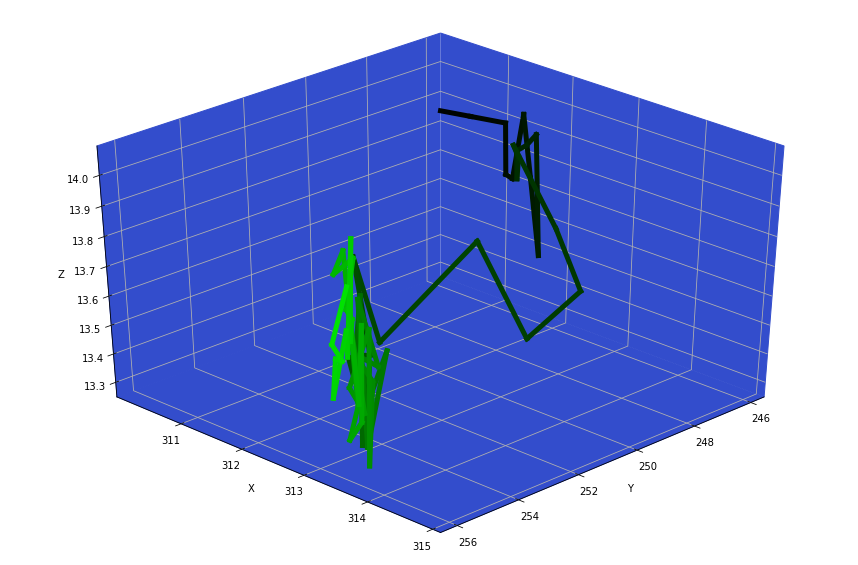

37


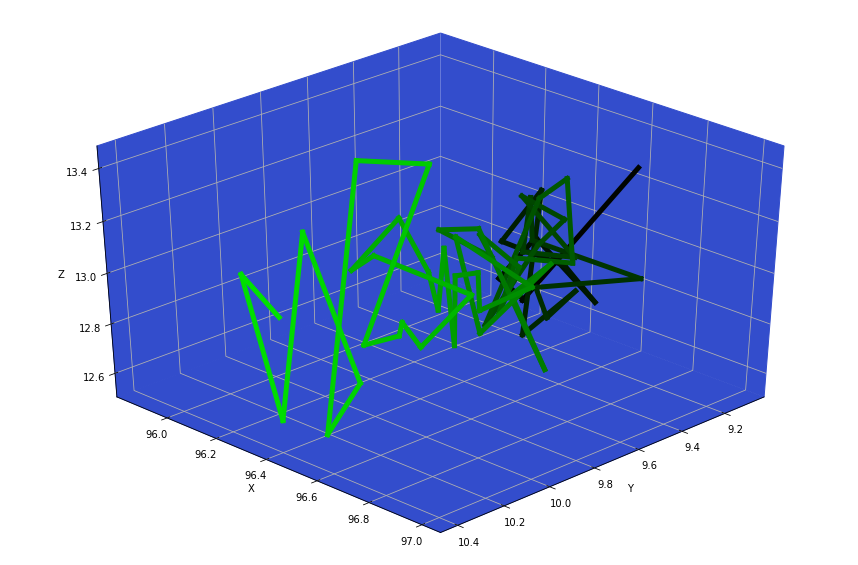

38


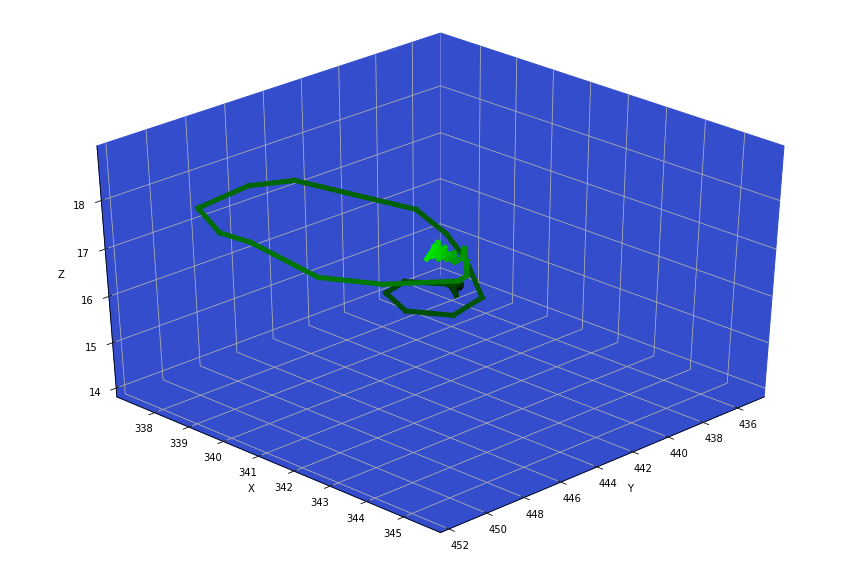

39


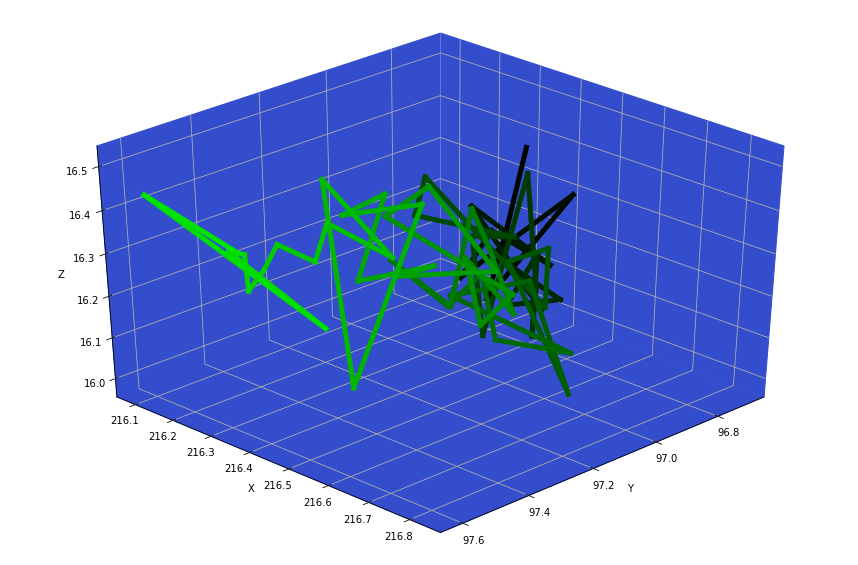

40


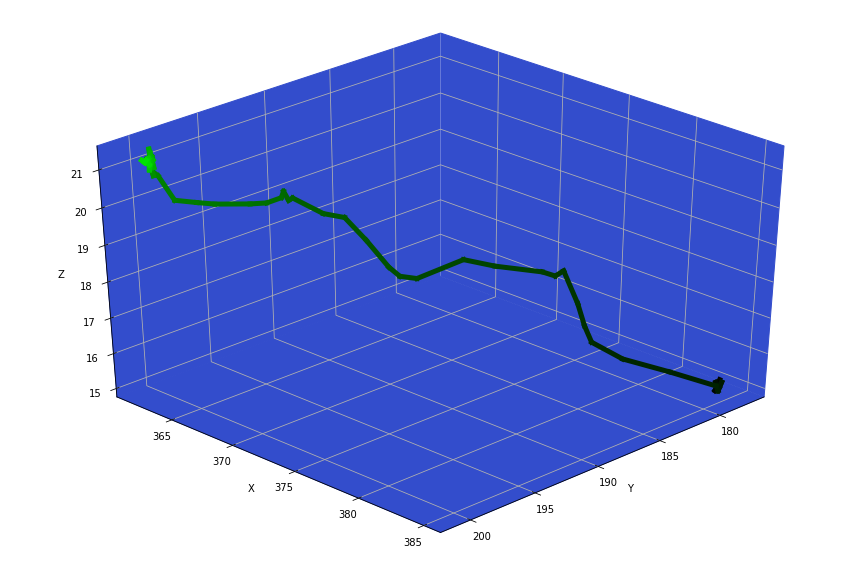

41


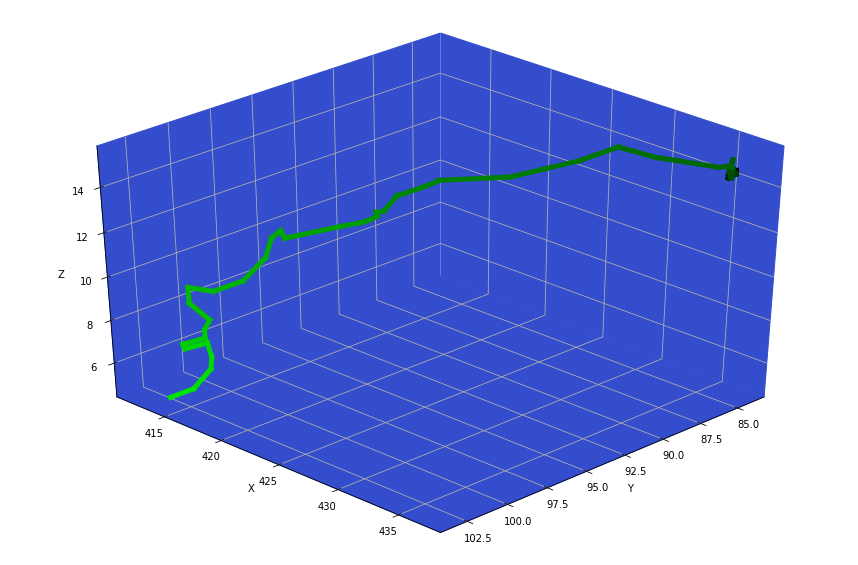

42


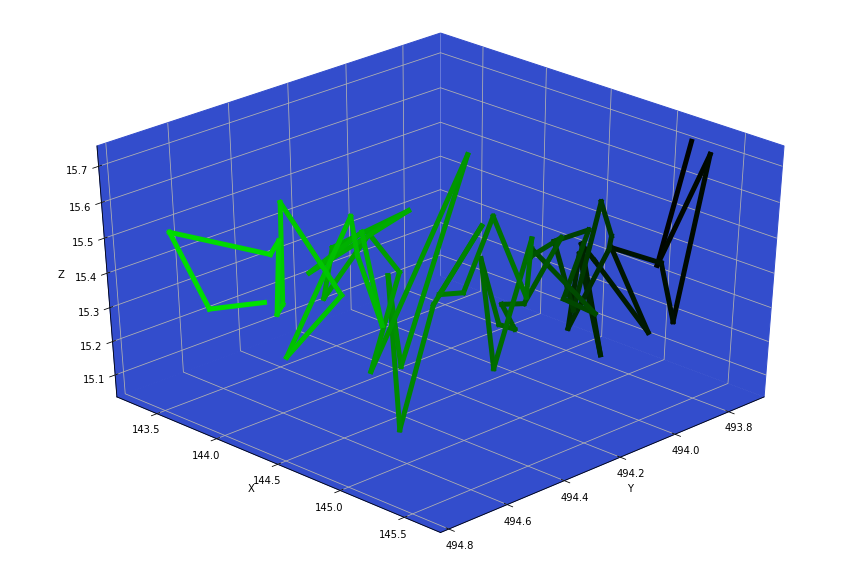

43


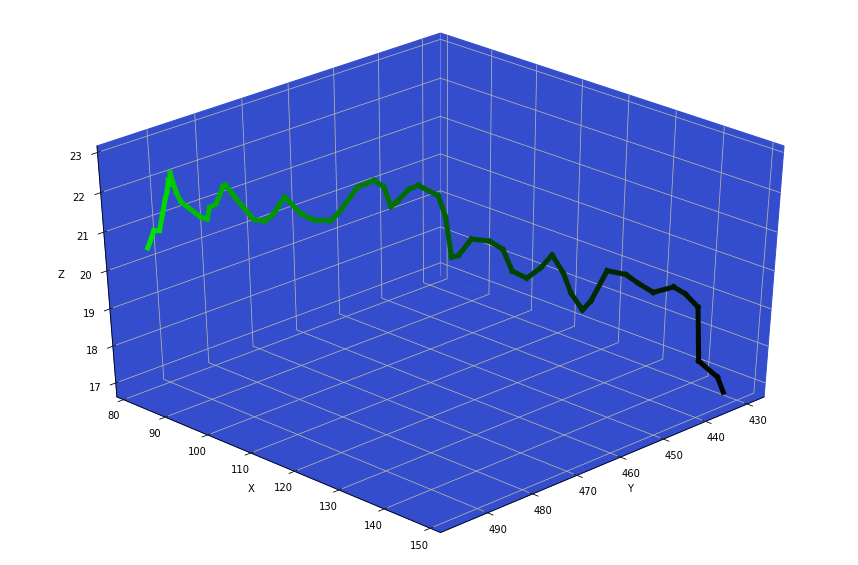

44


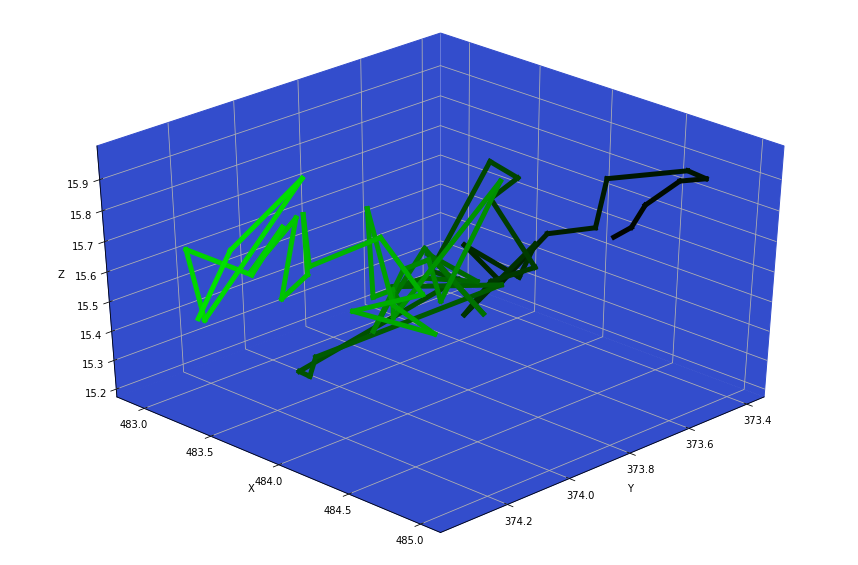

45


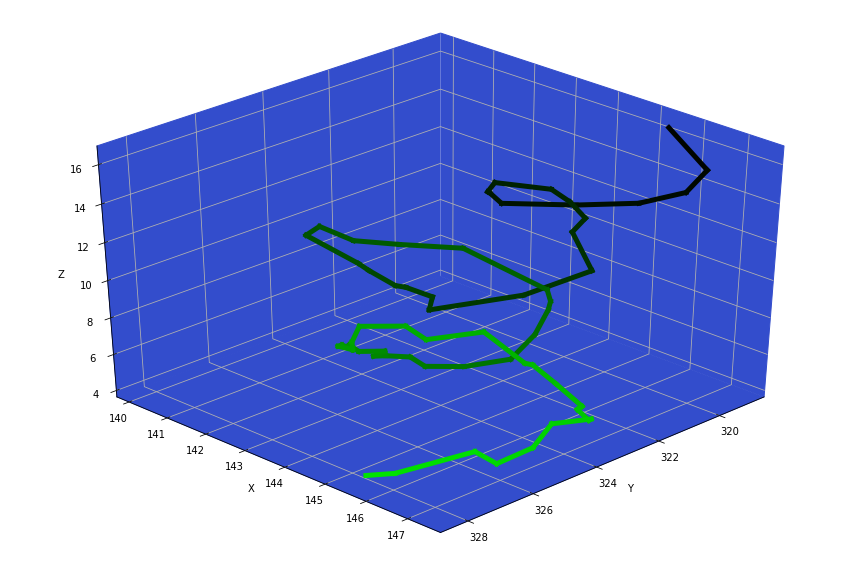

46


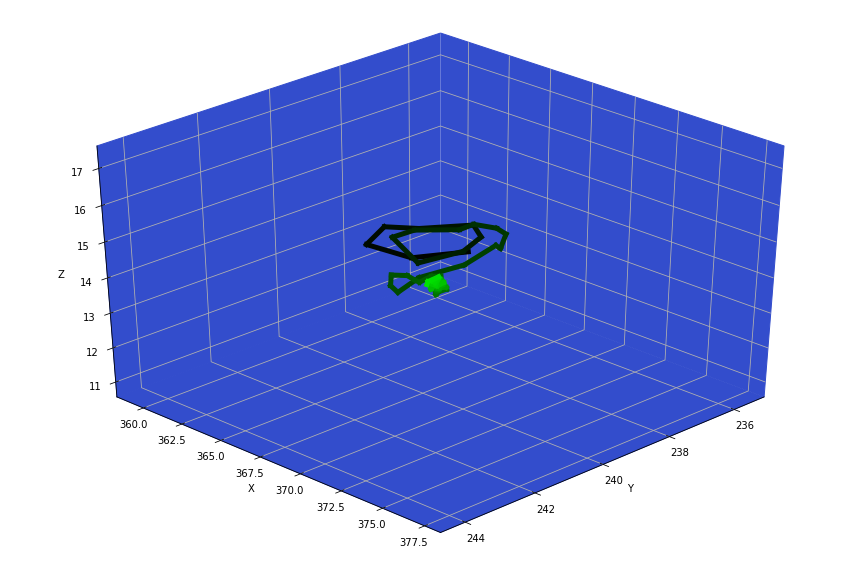

47


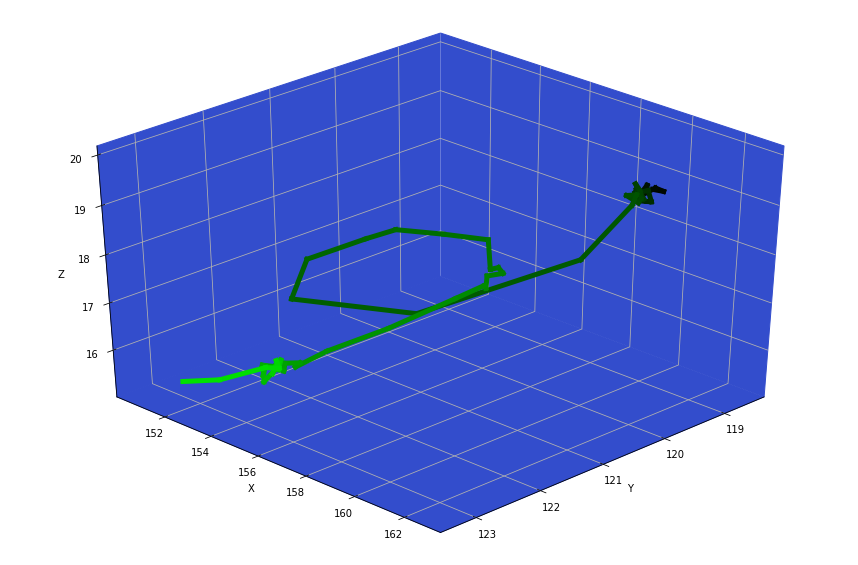

48


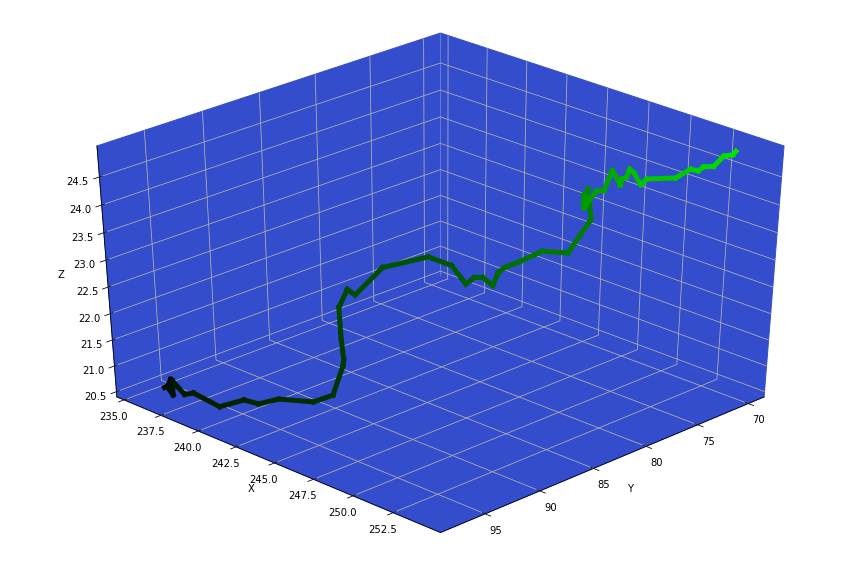

49


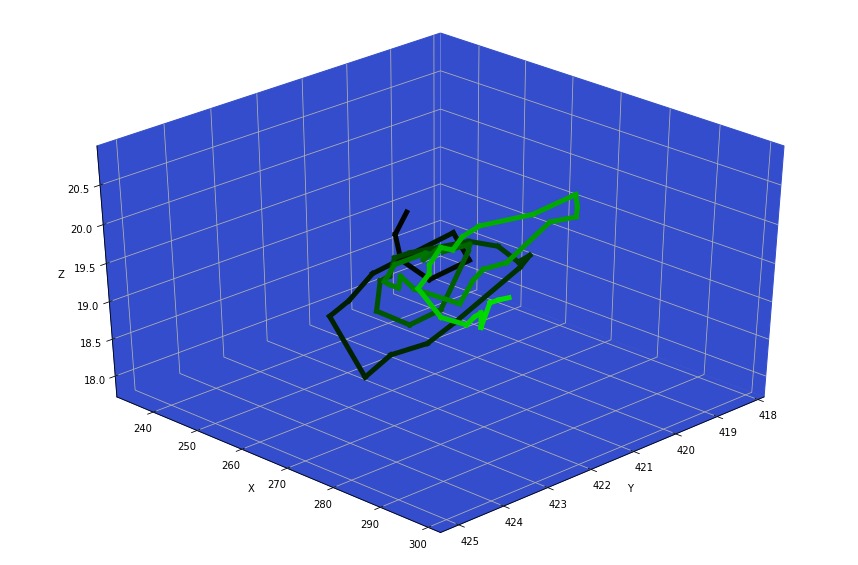

In [101]:
# Plotting the time variant trajectories of some single cells 

for i in range (36,50):
    print(i)
    Trajectory_3D_TimeVarying(63, True, i, 1, xx, yy, zz, len(new_objects), 'video_file')